In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
import pywt
import pywt.data
from filterpy.kalman import KalmanFilter
from numpy import array, asarray
import pycwt as wavelet
from pycwt.helpers import find
from matplotlib import pyplot
import math
from filterpy.common import pretty_str, reshape_z

In [2]:
def matrixPow(Matrix,n):
    if(type(Matrix)==list):
        Matrix=np.array(Matrix)
    if(n==0):
        return np.eye(Matrix.shape[0])
    elif(n==1):
        return Matrix
    else:
        return np.matmul(Matrix,matrixPow(Matrix,n-1))

In [34]:
# a = np.array([[0.5, 0.5]])
# b = np.array([[1,2,3,4,5,6]])
a = np.array([0.5, 0.5])
a_ = np.array([0.5, 0, 0, 0.5, 0, 0])
b = np.array([1, 2, 3, 4, 5, 6])

In [37]:
c = np.convolve(a.T,b.T,mode='full')
print(c[1:])

[1.5 2.5 3.5 4.5 5.5 3. ]


In [45]:
np.convolve(a_,c[1:],mode='same')

array([1.75, 3.  , 4.  , 3.25, 2.25, 2.75])

In [62]:
# pywt.families()
pywt.wavelist(family=None, kind='all') 

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'haar',
 'mexh',
 'morl',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',

[ 0.         0.6830127  1.1830127  0.3169873 -0.1830127  0.
  0.       ]


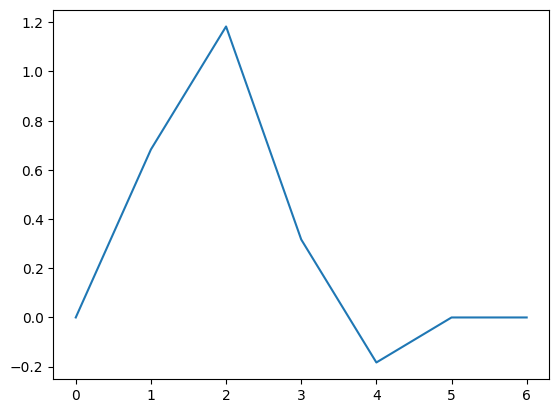

In [7]:
w = pywt.Wavelet('db2')
phi, psi, x = w.wavefun(level=1)
plt.plot(phi)
print(phi)

In [3]:
# x = Fx + Bw
# z = Hx + v
class Kalman(object):
    def __init__(self, dim_x, dim_z, dim_u=0):
        self.dim_x = dim_x
        self.dim_z = dim_z
        self.dim_u = dim_u

        self.x = np.zeros((dim_x, 1))        # state
        self.P = np.eye(dim_x)*0.1               # uncertainty covariance
        self.Q = np.eye(dim_x)               # process uncertainty
        self.Q_w = np.eye(dim_x)
        self.B = None                     # noise transition matrix
        self.F = np.eye(dim_x)               # state transition matrix
        self.f = np.eye(dim_x)
        self.H = np.zeros((dim_z, dim_x))    # measurement function
        self.R = np.eye(dim_z)               # measurement uncertainty
        self._alpha_sq = 1.               # fading memory control
#         self.M = np.zeros((dim_x, a1)) # process-measurement cross correlation
        self.w = np.zeros((dim_x, 1))
        self.z = np.array([[None]*self.dim_z]).T
        self.Psi = None
        self.n = 0
        # gain and residual are computed during the innovation step. We
        # save them so that in case you want to inspect them for various
        # purposes
        self.K = np.zeros((dim_x, dim_z)) # kalman gain
        self.L = np.zeros((dim_x, dim_z))
        self.y = np.zeros((dim_z, 1))
        self.S = np.zeros((dim_z, dim_z)) # system uncertainty
        self.SI = np.zeros((dim_z, dim_z)) # inverse system uncertainty
        self.I_KH = np.zeros((dim_x, dim_x))

        # identity matrix. Do not alter this.
        self._I = np.eye(dim_x)
        # these will always be a copy of x,P after predict() is called
        self.x_prior = self.x.copy()
        self.P_prior = self.P.copy()

        # these will always be a copy of x,P after update() is called
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()
        
        self.inv = np.linalg.inv
    def predict(self, B=None, H=None, F=None, Q=None):
        if B is None:
            B = self.B
        if H is None:
            H = self.H
        if F is None:
            F = self.F
        if Q is None:
            Q = self.Q
            
        # x_ = Fx_ + Ly
        self.x = np.dot(F, self.x)
        # P_ = FPF' + BQB'
        self.P = np.dot(F,np.dot(self.P,F.T)) + B@Q@B.T
    def update(self, z, R=None, H=None):
        if z is None:
            self.z = np.array([[None]*self.dim_z]).T
            self.x_post = self.x.copy()
            self.P_post = self.P.copy()
            self.y = zeros((self.dim_z, 1))
            return

        if R is None:
            R = self.R

        if H is None:
            z = reshape_z(z, self.dim_z, self.x.ndim)
            H = self.H

        # y = z - Hx
        # error (residual) between measurement and prediction
        self.y = z - np.dot(H, self.x)

        # common subexpression for speed
        PHT = np.dot(self.P, H.T)

        # S = HPH' + R
        # project system uncertainty into measurement space
        self.S = np.dot(H, PHT) + R
        self.SI = self.inv(self.S)
        # K = PH'inv(S)
        # map system uncertainty into kalman gain
        self.K = np.dot(PHT, self.SI)

        # x = x + Ky
        # predict new x with residual scaled by the kalman gain
        self.x = self.x + np.dot(self.K, self.y)

        # P = (I-KH)P(I-KH)' + KRK'
        # This is more numerically stable
        # and works for non-optimal K vs the equation
        # P = (I-KH)P usually seen in the literature.

        self.I_KH = self._I - np.dot(self.K, H)
        self.P = self.P - np.dot(np.dot(self.K, self.S), self.K.T)
#         print(I_KH,'---')
        # save measurement and posterior state
#         self.z = deepcopy(z)
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()


In [4]:
# 测量结果只能在最精细的尺度上可用（2维状态方程）噪声大，小波适用；噪声小，整数倍适用
n1 = 1
n2 = 2
n3 = 6
L0 = 240
L1 = int(L0/n1)
L2 = int(L0/n2)
L3 = int(L0/n3)

# data_size = 8
T = 0.1
P = 0.1*np.eye(2)

r1 = np.array([[1]])
r2 = np.array([[0.1]])
r3 = np.array([[0.01]])
# r1 = np.array([[2.25]])
# r2 = np.array([[1.69]])
# r3 = np.array([[1.44]])

F = np.array([[0.95]])

b = np.array([[1]])

C1 = np.array([[1.]])
C2 = np.array([[1.]])
C3 = np.array([[1.]])

Q = np.array([[0.5]])

# a1 = -0.3535533905932738/np.sqrt(2)
# a2 = 1.0606601717798212/np.sqrt(2)
# a3 = 1.0606601717798212/np.sqrt(2)
# a4 = -0.3535533905932738/np.sqrt(2)
# a1 = 0.6830127*0.5
# a2 = 1.1830127*0.5
# a3 = 0.3169873*0.5
# a4 = -0.1830127*0.5
a4 = 0.6830127*0.5
a3 = 1.1830127*0.5
a2 = 0.3169873*0.5
a1 = -0.1830127*0.5
# M = np.array([0.6830127, 1.1830127, 0.3169873, -0.1830127])/2
M = np.array([a1,a2,a3,a4])
# MN = np.array([0.1166265870903225,0.2020031745903225,0.25612976249999997,0.31862976249999997,0.14787658831935502,0.039623413319355004,-0.006129762499999997,-0.0686297625,-0.014503175409677502,0.0083734120903225])
MN = np.array([a1*a1,a1*a2,a1*a3+a2*a1,a1*a4+a2*a2,a2*a3+a3*a1,a2*a4+a3*a2,a3*a3+a4*a1,a3*a4+a4*a2,a4*a3,a4*a4])
# 状态只能有一个，剩下的都是向该状态采样获得
def generate_signal():
    x1 = np.zeros((1,L1+1))
    x2 = np.zeros((1,L2))
    x3 = np.zeros((1,L3))
    w1 = random.normal(0, Q, (1,L1+1))
    x1[:,0] = 0.2
    for i in range(L1):
        x1[:,i+1] = np.dot(F, x1[:,i]) + np.dot(b.T, w1[:,i])
    
#     for i in range(1,L2):
#         x_ = 0
#         for m in range(n2):
#             x_ += x1[:,n2*(i-1)+1+m]
#         x2[:,i] = x_/n2
    
#     for i in range(1,L3):
#         x_ = 0
#         for m in range(n3):
#             x_ += x1[:,n3*(i-1)+1+m]
#         x3[:,i] = x_/n3
        
#     for i in range(1,L2+1):
#         x2[:,i-1] = x1[:,n2*(i-1)+1]
    
#     for i in range(1,L3+1):
#         x3[:,i-1] = x1[:,n3*(i-1)+3]

#     for i in range(1,L2+1):
#         x_ = 0
#         for m in range(n2+2):
#             if n2*(i-1)-1+m < 0:
#                 x_ += 0
# #                 print(0)
#             elif n2*(i-1)-1+m == L1:
#                 x_ +=x1[:,n2*(i-1)-2+m]
# #                 print(n2*(i-1)-2+m)
#             else:
#                 x_ += x1[:,n2*(i-1)-1+m]
# #                 print(n2*(i-1)-1+m)
#         x2[:,i-1] = x_/(n2+2)
#     for i in range(1,L3+1):
#         x_ = 0
#         for m in range(n3+2):
#             if n3*(i-1)-1+m < 0:
#                 x_ +=0
# #                 print(0)
#             elif n3*(i-1)-1+m == L1:
#                 x_ += x1[:,n3*(i-1)-2+m]
# #                 print(n3*(i-1)-2+m)
#             else:
#                 x_ += x1[:,n3*(i-1)-1+m]
# #                 print(n3*(i-1)-1+m)
#         x3[:,i-1] = x_/(n3+2)
#     for i in range(1,L3+1):
#     x3[:,i-1] = x1[:,n3*(i-1)+3]
#     print(n3*(i-1)+3)

    for i in range(1,L2+1):
        x_ = 0
        for m in range(n2+2):
            if n2*(i-1)-1+m < 0:
                x_ += 0
#                 print(0)
            elif n2*(i-1)-1+m == L1:
                x_ +=x1[:,n2*(i-1)-2+m]*M[m]
#                 print(n2*(i-1)-2+m)
            else:
                x_ += x1[:,n2*(i-1)-1+m]*M[m]
#                 print(n2*(i-1)-1+m)
        x2[:,i-1] = x_
    for i in range(1,L3+1):
        x_ = 0
        for m in range(n3+4):
            if n3*(i-1)-3+m < 0:
                x_ +=0
#                 print(0)
            elif n3*(i-1)-3+m == L1:
                x_ += x1[:,n3*(i-1)-4+m]*MN[m]
#                 print(n3*(i-1)-4+m)
            else:
                x_ += x1[:,n3*(i-1)-3+m]*MN[m]
#                 print(n3*(i-1)-3+m)
        x3[:,i-1] = x_

    y1 = random.normal(0, np.sqrt(r1[0][0]), L1)
    y2 = random.normal(0, np.sqrt(r2[0][0]), L2)
    y3 = random.normal(0, np.sqrt(r3[0][0]), L3)

    zs1 = (np.dot(C1, x1[:,:-1]) + y1)[0]
    zs2 = (np.dot(C2, x2) + y2)[0]
    zs3 = (np.dot(C3, x3) + y3)[0]
    return x1,x2,x3,zs1,zs2,zs3

def generate_signal0():
    x1 = np.zeros((1,L1+1))
    x2 = np.zeros((1,L2))
    x3 = np.zeros((1,L3))
    w1 = random.normal(0, Q, (1,L1+1))
    for i in range(L1):
        x1[:,i+1] = np.dot(F, x1[:,i]) + np.dot(b.T, w1[:,i])
    
    for i in range(1,L2+1):
        x2[:,i-1] = x1[:,n2*(i-1)+1]
    
    for i in range(1,L3+1):
        x3[:,i-1] = x1[:,n3*(i-1)+3]
    
    y1 = random.normal(0, np.sqrt(r1[0][0]), L1)
    y2 = random.normal(0, np.sqrt(r2[0][0]), L2)
    y3 = random.normal(0, np.sqrt(r3[0][0]), L3)

    zs1 = (np.dot(C1, x1[:,:-1]) + y1)[0]
    zs2 = (np.dot(C2, x2) + y2)[0]
    zs3 = (np.dot(C3, x3) + y3)[0]
    return x1,x2,x3,zs1,zs2,zs3

In [5]:
def fusion(zs0,A_, C_, R_, B_, Q_):
    xs = []
    # 建立Kalman滤波模型
    fk = KalmanFilter(dim_x=1, dim_z=1)
    fk.x = np.array([0.2])
    fk.B = B_
    fk.F = A_
    fk.H = C_
    fk.P = .01
    fk.R = R_
    fk.Q = Q_
    for j in range(int(len(zs0))):
        fk.predict()
        fk.update(zs0[j])
        xs.append(fk.x)
    xs = asarray(xs)
    return xs
def fusion_block(zs0, zs1, zs2, A_, C_, R_, B_, Q_, data_size1, data_size2):
    xs = []
    # 建立Kalman滤波模型
#     fk = KalmanFilter(dim_x = 10, dim_z = 10)
    fk = Kalman(dim_x = 10, dim_z = 10)
    fk.x = np.array([0.2]*10)
    fk.B = B_
    fk.F = A_
    fk.H = C_
    fk.P = .01
    fk.R = R_
    fk.Q = Q_
    for j in range(int(len(zs0)/(data_size1*data_size2))):
#         x_ = x0[0,data_size*j:data_size*(j+1)]
#         if(j==0):
#             z_ = np.concatenate((zs1[j:(j+1)].reshape(1,),zs0[data_size*j:data_size*(j+1)]), axis=0)
#         else:
        z_ = np.concatenate((zs2[j:(j+1)].reshape(1,),zs1[data_size2*j:data_size2*(j+1)],
                             zs0[data_size2*data_size1*j:data_size2*data_size1*(j+1)]), axis=0)
        fk.predict()
        fk.update(z_)
        xs.append(fk.x)
    xs = asarray(xs)
    return xs
def fusion_average(zs1, zs2, zs3, Aa_, Cc_, Rr_, Bb_, Qq_, data_size1, data_size2):
    xs = []
    # 建立Kalman滤波模型
#     fk = KalmanFilter(dim_x = 10, dim_z = 10)
    fk = Kalman(dim_x = 6, dim_z = 10)
    fk.x = np.array([0]*6)
    fk.B = Bb_
    fk.F = Aa_
    fk.H = Cc_
    fk.P = .01
    fk.R = Rr_
    fk.Q = Qq_
    for j in range(int(len(zs1)/(data_size1*data_size2))):
        z_ = np.concatenate((zs3[j:(j+1)].reshape(1,),zs2[data_size2*j:data_size2*(j+1)],
                             zs1[data_size2*data_size1*j:data_size2*data_size1*(j+1)]), axis=0)
        fk.predict()
        fk.update(z_)
        xs.append(fk.x)
    xs = asarray(xs)
    return xs
def fusion_haar(zs0, zs1, zs2, A_, C_, R_, B_, Q_, data_size1, data_size2):
    xs = []
    # 建立Kalman滤波模型
#     fk = KalmanFilter(dim_x = 10, dim_z = 10)
    fk = Kalman(dim_x = 6, dim_z = 10)
    fk.x = np.array([0]*6)
    fk.B = B_
    fk.F = A_
    fk.H = C_
    fk.P = .01
    fk.R = R_
    fk.Q = Q_
    for j in range(int(len(zs0)/(data_size1*data_size2))):
        z_ = np.concatenate((zs2[j:(j+1)].reshape(1,),zs1[data_size2*j:data_size2*(j+1)],
                             zs0[data_size2*data_size1*j:data_size2*data_size1*(j+1)]), axis=0)
        fk.predict()
        fk.update(z_)
        xs.append(fk.x)
    xs = asarray(xs)
    return xs

In [208]:
q = np.array([[0.5]])
xs_1 = fusion(zs1,F, C1, r1, b, q)

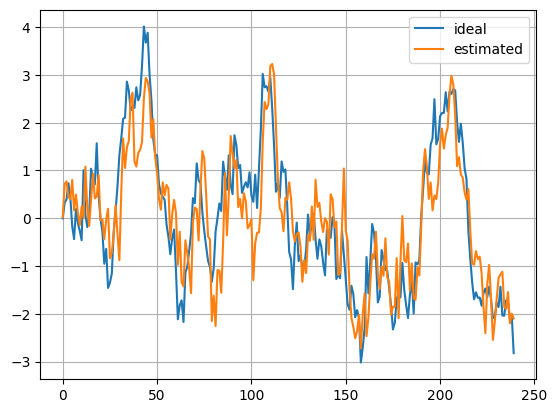

In [209]:
plt.plot(x1[0,:-1],label='ideal')
plt.plot(xs_1.reshape(240,1),label='estimated')
plt.grid(visible=True, axis='x')
plt.grid(visible=True, axis='y')
plt.legend()

In [28]:
nom1 = x0[0,:-1]
res1 = nom1 - xs_1.reshape(240,)
rms_dev1 = np.sqrt(np.sum(np.square(res1) / res1.shape[0]))
print('DWT_RMS1: {:.3f}'.format (rms_dev1))

DWT_RMS1: 0.900


## X_(k+1) = A**X_(k) + B**W_
## Z_(k) = C*X_(k) + V_

In [6]:
# Haar增广融合
# X_(k) = col{x1(6k),x1(6k+1),x1(6k+2),x1(6k+3),x1(6k+4),x1(6k+5)}
# W_(k) = col{w(6k),w(6k+1),w(6k+2),w(6k+3),w(6k+4),w(6k+5)}
Aaa = np.array([[0.,0.,0.,0.,0.,F[0][0]],
              [0.,0.,0.,0.,0.,matrixPow(F,2)[0][0]],
              [0.,0.,0.,0.,0.,matrixPow(F,3)[0][0]],
              [0.,0.,0.,0.,0.,matrixPow(F,4)[0][0]],
              [0.,0.,0.,0.,0.,matrixPow(F,5)[0][0]],
              [0.,0.,0.,0.,0.,matrixPow(F,6)[0][0]]])

Ccc = np.array([[0, 1/4, 1/4, 0, 1/4, 1/4],
              [1/2, 1/2, 0, 0, 0, 0],
              [0, 0, 1/2, 1/2, 0, 0],
              [0, 0, 0, 0, 1/2, 1/2],
              [1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]])


Rrr = np.diag([r3[0][0],r2[0][0],r2[0][0],r2[0][0],r1[0][0],r1[0][0],r1[0][0],r1[0][0],r1[0][0],r1[0][0]])

Bbb = np.array([[b[0][0],0,0,0,0,0],
              [(F@b)[0][0],b[0][0],0,0,0,0],
              [(matrixPow(F,2)@b)[0][0],(F@b)[0][0],b[0][0],0,0,0],
              [(matrixPow(F,3)@b)[0][0],(matrixPow(F,2)@b)[0][0],(F@b)[0][0],b[0][0],0,0],
              [(matrixPow(F,4)@b)[0][0],(matrixPow(F,3)@b)[0][0],(matrixPow(F,2)@b)[0][0],(F@b)[0][0],b[0][0],0],
              [(matrixPow(F,5)@b)[0][0],(matrixPow(F,4)@b)[0][0],(matrixPow(F,3)@b)[0][0],(matrixPow(F,2)@b)[0][0],(F@b)[0][0],b[0][0]]])
Qq_ = np.diag([Q[0][0]]*6)

In [7]:
# 平均增广融合
# X_(k) = col{x1(6k),x1(6k+1),x1(6k+2),x1(6k+3),x1(6k+4),x1(6k+5)}
# W_(k) = col{w(6k),w(6k+1),w(6k+2),w(6k+3),w(6k+4),w(6k+5)}
Aa = np.array([[0.,0.,0.,0.,0.,F[0][0]],
              [0.,0.,0.,0.,0.,matrixPow(F,2)[0][0]],
              [0.,0.,0.,0.,0.,matrixPow(F,3)[0][0]],
              [0.,0.,0.,0.,0.,matrixPow(F,4)[0][0]],
              [0.,0.,0.,0.,0.,matrixPow(F,5)[0][0]],
              [0.,0.,0.,0.,0.,matrixPow(F,6)[0][0]]])

Cc = np.array([[1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
              [1/2, 1/2, 0, 0, 0, 0],
              [0, 0, 1/2, 1/2, 0, 0],
              [0, 0, 0, 0, 1/2, 1/2],
              [1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]])


Rr = np.diag([r3[0][0],r2[0][0],r2[0][0],r2[0][0],r1[0][0],r1[0][0],r1[0][0],r1[0][0],r1[0][0],r1[0][0]])

Bb = np.array([[b[0][0],0,0,0,0,0],
              [(F@b)[0][0],b[0][0],0,0,0,0],
              [(matrixPow(F,2)@b)[0][0],(F@b)[0][0],b[0][0],0,0,0],
              [(matrixPow(F,3)@b)[0][0],(matrixPow(F,2)@b)[0][0],(F@b)[0][0],b[0][0],0,0],
              [(matrixPow(F,4)@b)[0][0],(matrixPow(F,3)@b)[0][0],(matrixPow(F,2)@b)[0][0],(F@b)[0][0],b[0][0],0],
              [(matrixPow(F,5)@b)[0][0],(matrixPow(F,4)@b)[0][0],(matrixPow(F,3)@b)[0][0],(matrixPow(F,2)@b)[0][0],(F@b)[0][0],b[0][0]]])
Qq_ = np.diag([Q[0][0]]*6)

In [102]:
a1+a2+a3+a4

1.0

In [8]:
# 小波多尺度增广融合
# X_(k) = col{x1(3k-1),x1(3k),x1(3k+1),x1(3k+2)}
# W_(k) = col{w(3k),w(3k+1),w(3k+2)}
coeff = 1/2
# a1 = 0.6830127*coeff
# a2 = 1.1830127*coeff
# a3 = 0.3169873*coeff
# a4 = -0.1830127*coeff
a4 = 0.6830127*coeff
a3 = 1.1830127*coeff
a2 = 0.3169873*coeff
a1 = -0.1830127*coeff
# a1 = -0.3535533905932738/np.sqrt(2)
# a2 = 1.0606601717798212/np.sqrt(2)
# a3 = 1.0606601717798212/np.sqrt(2)
# a4 = -0.3535533905932738/np.sqrt(2)
# haar = np.sqrt(2)/2
# zero = np.array([[0,0,0]])
# zeros = np.array([[0,0,0],[0,0,0],[0,0,0]])
# one = np.array([[1,0,0],[0,1,0],[0,0,1]])

A = np.array([[0.,0.,0.,0.,0.,0.,1.,0.,0.,0.],
              [0.,0.,0.,0.,0.,0.,0.,1.,0.,0.],
              [0.,0.,0.,0.,0.,0.,0.,0.,1.,0.],
              [0.,0.,0.,0.,0.,0.,0.,0.,0.,1.],
              [0.,0.,0.,0.,0.,0.,0.,0.,0.,F[0][0]],
              [0.,0.,0.,0.,0.,0.,0.,0.,0.,matrixPow(F,2)[0][0]],
              [0.,0.,0.,0.,0.,0.,0.,0.,0.,matrixPow(F,3)[0][0]],
              [0.,0.,0.,0.,0.,0.,0.,0.,0.,matrixPow(F,4)[0][0]],
              [0.,0.,0.,0.,0.,0.,0.,0.,0.,matrixPow(F,5)[0][0]],
              [0.,0.,0.,0.,0.,0.,0.,0.,0.,matrixPow(F,6)[0][0]]])

C = np.array([[a1*a1,a1*a2,a1*a3+a2*a1,a1*a4+a2*a2,a2*a3+a3*a1,a2*a4+a3*a2,a3*a3+a4*a1,a3*a4+a4*a2,a4*a3,a4*a4],
              [0,0,a1, a2, a3, a4,0,0,0,0],
              [0,0,0,0,a1, a2, a3, a4,0,0],
              [0,0,0,0,0,0,a1, a2, a3, a4],
              [0,0,0,1,0,0,0,0,0,0],
              [0,0,0,0,1,0,0,0,0,0],
              [0,0,0,0,0,1,0,0,0,0],
              [0,0,0,0,0,0,1,0,0,0],
              [0,0,0,0,0,0,0,1,0,0],
              [0,0,0,0,0,0,0,0,1,0]])


R = np.diag([r3[0][0],r2[0][0],r2[0][0],r2[0][0],r1[0][0],r1[0][0],r1[0][0],r1[0][0],r1[0][0],r1[0][0]])

B = np.array([[0,0,0,0,0,0],
              [0,0,0,0,0,0],
              [0,0,0,0,0,0],
              [0,0,0,0,0,0],
              [b[0][0],0,0,0,0,0],
              [(F@b)[0][0],b[0][0],0,0,0,0],
              [(matrixPow(F,2)@b)[0][0],(F@b)[0][0],b[0][0],0,0,0],
              [(matrixPow(F,3)@b)[0][0],(matrixPow(F,2)@b)[0][0],(F@b)[0][0],b[0][0],0,0],
              [(matrixPow(F,4)@b)[0][0],(matrixPow(F,3)@b)[0][0],(matrixPow(F,2)@b)[0][0],(F@b)[0][0],b[0][0],0],
              [(matrixPow(F,5)@b)[0][0],(matrixPow(F,4)@b)[0][0],(matrixPow(F,3)@b)[0][0],(matrixPow(F,2)@b)[0][0],(F@b)[0][0],b[0][0]]])
Q_ = np.diag([Q[0][0]]*6)

In [54]:
C

array([[ 0.00837341, -0.01450318, -0.06862976, -0.00612976,  0.03962341,
         0.14787659,  0.31862976,  0.25612976,  0.20200317,  0.11662659],
       [ 0.        ,  0.        , -0.09150635,  0.15849365,  0.59150635,
         0.34150635,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.09150635,
         0.15849365,  0.59150635,  0.34150635,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.09150635,  0.15849365,  0.59150635,  0.34150635],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        

In [9]:
x1,x2,x3,zs1,zs2,zs3 = generate_signal0()

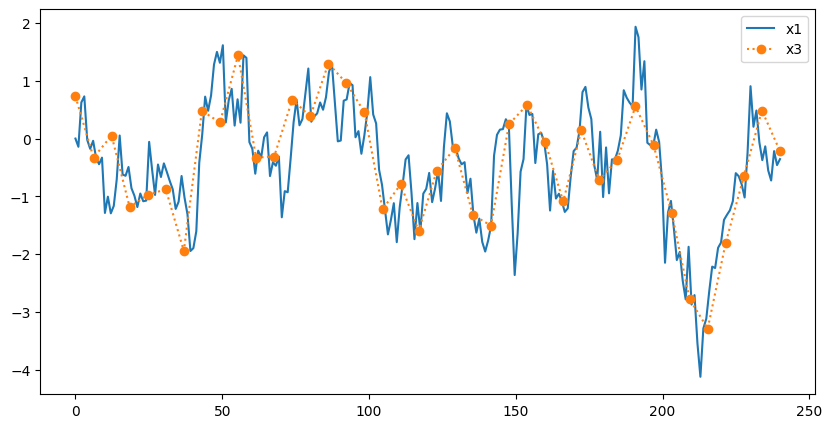

In [51]:
t1 = np.linspace(0,240,L1)
t2 = np.linspace(0,240,L2)
t3 = np.linspace(0,240,L3)
# t4 = np.linspace(0,240,L4)
# t5 = np.linspace(0,240,L5)
plt.figure(figsize=(10,5),dpi=100)
# 状态
plt.plot(t1,x1[0,:-1],label='x1')
# plt.plot(t2,x2[0],'o:',label='x2')
plt.plot(t3,x3[0],'o:',label='x3')
# plt.plot(t4,x4[0],'o:',label='x4')
# plt.plot(t5,x5[0],'o:',label='x5')
# 量测
# plt.plot(t1,zs1,label='zs1')
# plt.plot(t2,zs2,'o:',label='zs2')
# plt.plot(t3,zs3,'o:',label='zs3')
# plt.plot(t4,zs4,'o:',label='zs4')
# plt.plot(t5,zs5,'o:',label='zs5')
plt.legend()

In [85]:
xs = fusion_block(zs1, zs2, zs3, A, C, R, B, Q_, 2, 3)

In [11]:
xs_ave = fusion_average(zs1, zs2, zs3, Aa, Cc, Rr, Bb, Qq_, 2, 3)

In [92]:
X_e0 = []
for i in range(int(len(zs1)/(3*2))):
    X_e0.append(xs[i,3:-1])
X_e0 = asarray(X_e0)

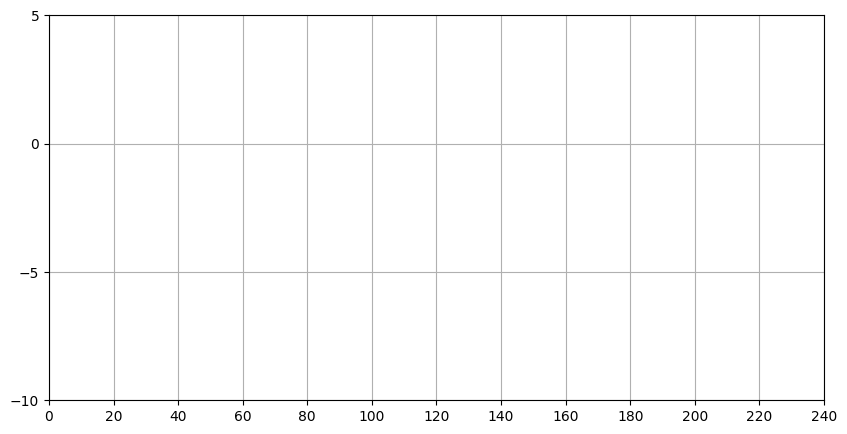

In [83]:
plt.figure(figsize=(10,5),dpi=100)
x = range(L0)
z = range(-10, 10)
x_label = ["{}".format(i) for i in range(L0+20)]
plt.xticks(range(L0+20)[::20], x_label[::20])
plt.yticks(z[::5])
plt.grid(visible=True, axis='x')
plt.grid(visible=True, axis='y')

DWT_RMS0: 0.626


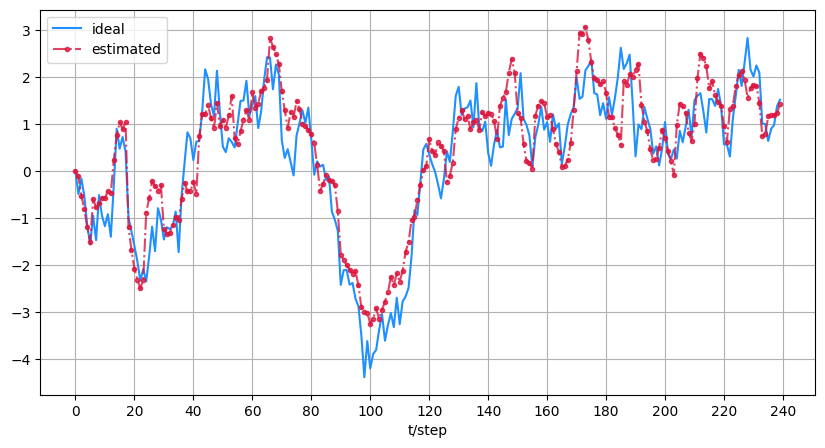

In [127]:
nom0 = x1[0,:-1]
res0 = nom0 - X_e0.reshape(L1,)
rms_dev0 = np.sqrt(np.sum(np.square(res0) / res0.shape[0]))
print('DWT_RMS0: {:.3f}'.format (rms_dev0))
# 画图
plt.figure(figsize=(10,5),dpi=200)
plt.plot(x1[0,:-1],color='dodgerblue',label='ideal')
plt.plot(X_e0.reshape(L1,1),color='crimson',marker='.',linestyle='-.',alpha=0.8,label='estimated')
plt.grid(visible=True, axis='x')
plt.grid(visible=True, axis='y')
# 设置刻度和步长
x_label = ["{}".format(i) for i in range(L1+20)]
plt.xticks(range(L1+20)[::20], x_label[::20])
# plt.yticks(range(-5, 10)[::5])
plt.xlabel('t/step')
plt.legend()

DWT_RMS0: 0.654


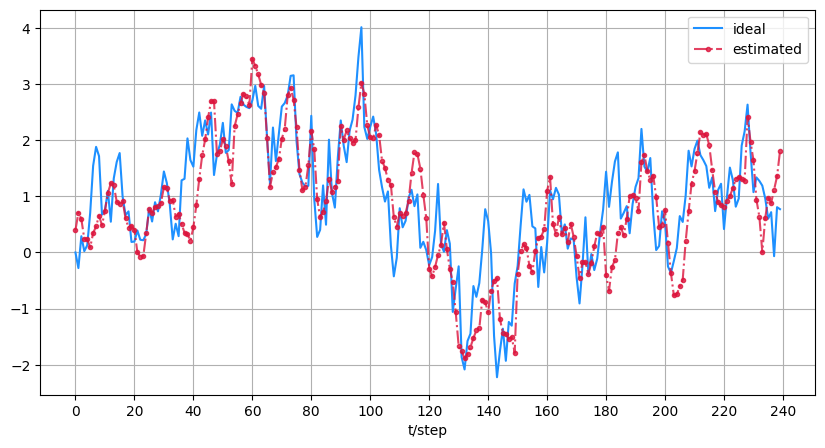

In [12]:
nom0 = x1[0,:-1]
res0 = nom0 - xs_ave.reshape(L1,)
rms_dev0 = np.sqrt(np.sum(np.square(res0) / res0.shape[0]))
print('DWT_RMS0: {:.3f}'.format (rms_dev0))
# 画图
plt.figure(figsize=(10,5),dpi=100)
plt.plot(x1[0,:-1],color='dodgerblue',label='ideal')
plt.plot(xs_ave.reshape(L1,1),color='crimson',marker='.',linestyle='-.',alpha=0.8,label='estimated')
plt.grid(visible=True, axis='x')
plt.grid(visible=True, axis='y')
# 设置刻度和步长
x_label = ["{}".format(i) for i in range(L1+20)]
plt.xticks(range(L1+20)[::20], x_label[::20])
# plt.yticks(range(-5, 10)[::5])
plt.xlabel('t/step')
plt.legend()

## 增广融合-闫莉萍

In [33]:
# def create_nI(n,Mi):
#     a = np.eye(n,n)
#     e = np.eye(n,n)
#     for i in range(Mi-1):
#         e = np.concatenate((a,e),axis=1)
#     return e

In [10]:
# 整数倍
N1 = int(L1/L2) # 2
N2 = int(L2/L3) # 3
Mn = N1*N2 # 6
M_1 = N1*N2
M_2 = N1
M_3 = 1
M1 = 1
M2 = N2
M3 = N1*N2

A_ = np.array([[0.,0.,0.,0.,0.,F[0][0]],
               [0.,0.,0.,0.,0.,matrixPow(F,2)[0][0]],
               [0.,0.,0.,0.,0.,matrixPow(F,3)[0][0]],
               [0.,0.,0.,0.,0.,matrixPow(F,4)[0][0]],
               [0.,0.,0.,0.,0.,matrixPow(F,5)[0][0]],
               [0.,0.,0.,0.,0.,matrixPow(F,6)[0][0]]])

C1_ = 1/M_3*np.array([[1,0,0,0,0,0],
                      [0,1,0,0,0,0],
                      [0,0,1,0,0,0],
                      [0,0,0,1,0,0],
                      [0,0,0,0,1,0],
                      [0,0,0,0,0,1]])

C2_ = 1/M_2*np.array([[1,1,0,0,0,0],
                      [0,0,1,1,0,0],
                      [0,0,0,0,1,1]])

C3_ = 1/M_1*np.array([[1,1,1,1,1,1]])

R1_ = np.diag([r1[0][0]]*6)
R2_ = np.diag([r1[0][0]]*3)
R3_ = np.diag([r2[0][0]])

B_ = np.array([[1,0,0,0,0,0],
               [F[0][0],1.,0.,0.,0.,0.],     
               [matrixPow(F,2)[0][0],F[0][0],1.,0.,0.,0.,],
               [matrixPow(F,3)[0][0],matrixPow(F,2)[0][0],F[0][0],1.,0.,0.,],
               [matrixPow(F,4)[0][0],matrixPow(F,3)[0][0],matrixPow(F,2)[0][0],F[0][0],1.,0.,],
               [matrixPow(F,5)[0][0],matrixPow(F,4)[0][0],matrixPow(F,3)[0][0],matrixPow(F,2)[0][0],F[0][0],1.,]])

Qq_ = np.diag([Q[0][0]]*6)

In [11]:
def fusion_ylp(zs0, zs1, zs2, A_, C1_, C2_, C3_, R1_, R2_, R3_, B_, Q_, data_size1, data_size2):
    xs = []
    xs1 = []
    xs2 = []
    xs3 = []
    # 建立Kalman滤波模型
    fk1 = Kalman(dim_x=6, dim_z=6)
    fk2 = Kalman(dim_x=6, dim_z=3)
    fk3 = Kalman(dim_x=6, dim_z=1)
    fk1.x = np.array([0]*6)
    fk2.x = np.array([0]*6)
    fk3.x = np.array([0]*6)
    fk1.B = B_
    fk2.B = B_
    fk3.B = B_
    fk1.F = A_
    fk2.F = A_
    fk3.F = A_
    fk1.H = C1_
    fk2.H = C2_
    fk3.H = C3_
    fk1.P = .01
    fk2.P = .01
    fk3.P = .01
    fk1.R = R1_
    fk2.R = R2_
    fk3.R = R3_
    fk1.Q = Q_
    fk2.Q = Q_
    fk3.Q = Q_
    
    for j in range(int(len(zs0)/(data_size1*data_size2))):
#         x_ = x0[0,data_size1*data_size2*j:data_size1*data_size2*(j+1)]
        z1_ = zs0[data_size1*data_size2*j:data_size1*data_size2*(j+1)]
        z2_ = zs1[data_size2*j:data_size2*(j+1)]
        z3_ = zs2[1*j:1*(j+1)]
        
        fk1.predict()
        fk1.update(z1_)
        xs1.append(fk1.x)

        fk2.predict()
        fk2.update(z2_)
        xs2.append(fk2.x)

        fk3.predict()
        fk3.update(z3_)
        xs3.append(fk3.x)

        beta = (np.trace(fk1.P)**(-1) + np.trace(fk2.P)**(-1) + np.trace(fk3.P)**(-1))**(-1)
        alpha1 = (beta) * np.trace(fk1.P)**(-1)
        alpha2 = (beta) * np.trace(fk2.P)**(-1)
        alpha3 = (beta) * np.trace(fk3.P)**(-1)
        xs.append(alpha1*fk1.x+alpha2*fk2.x+alpha3*fk3.x)
    xs = asarray(xs)
    xs1 = asarray(xs1)
    xs2 = asarray(xs2)
    xs3 = asarray(xs3)
    return xs

In [35]:
# # 整数倍
# xs = []
# xs1 = []
# xs2 = []
# xs3 = []
# P1 = []
# P2 = []
# P3 = []
# P_N = []
# for j in range(int(L1/Mn)):
#     x_ = x0[0,Mn*j:Mn*(j+1)]
#     z1_ = zs0[M3*j:M3*(j+1)]
#     z2_ = zs1[M2*j:M2*(j+1)]
#     z3_ = zs2[M1*j:M1*(j+1)]
#     #     w_ = w0[0,4*j:4*(j+1)]
#     #     v_ = np.concatenate((y2[j].reshape(1,),y1[2*j:2*(j+1)],y0[4*j:4*(j+1)]), axis=0)
#     fk1.predict()
#     fk1.update(z1_)
#     xs1.append(fk1.x)
    
#     fk2.predict()
#     fk2.update(z2_)
#     xs2.append(fk2.x)
    
#     fk3.predict()
#     fk3.update(z3_)
#     xs3.append(fk3.x)
    
#     beta = (np.trace(fk1.P)**(-1) + np.trace(fk2.P)**(-1) + np.trace(fk3.P)**(-1))**(-1)
#     alpha1 = (beta) * np.trace(fk1.P)**(-1)
#     alpha2 = (beta) * np.trace(fk2.P)**(-1)
#     alpha3 = (beta) * np.trace(fk3.P)**(-1)
#     xs.append(alpha1*fk1.x+alpha2*fk2.x+alpha3*fk3.x)
#     xs1.append()
#     P1.append(alpha1)
#     P2.append(alpha2)
#     P3.append(alpha3)

    
# xs1 = asarray(xs1)
# xs2 = asarray(xs2)
# xs3 = asarray(xs3)

In [62]:
x1,x2,x3,zs1,zs2,zs3 = generate_signal()

In [66]:
xs = fusion_ylp(zs1, zs2, zs3, A_, C1_, C2_, C3_, R1_, R2_, R3_, B_, Qq_, 2, 3)

## 标量融合这部分错了，参照会议那篇文章

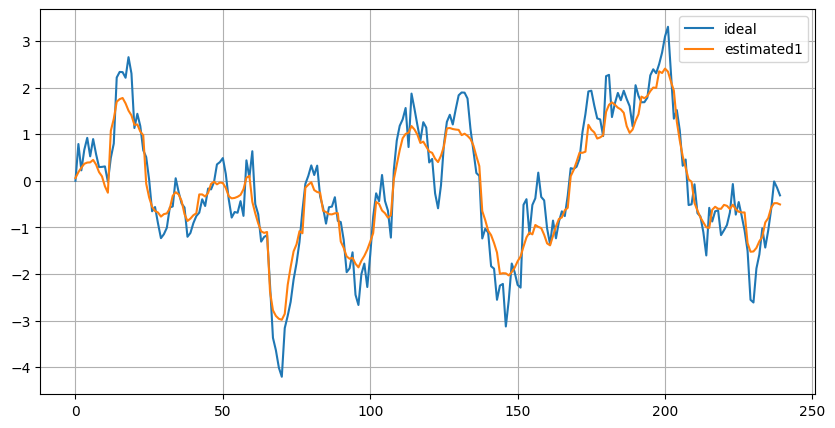

In [67]:
plt.figure(figsize=(10,5),dpi=100)
# plt.plot(zs0,label='measurement')
plt.plot(x1[0,:-1],label='ideal')
plt.plot(xs.reshape(L1,),label='estimated1')
# plt.plot(xs2.reshape(L0,),label='estimated2')
# plt.plot(xs3.reshape(L0,),label='estimated3')
plt.grid(visible=True, axis='x')
plt.grid(visible=True, axis='y')
plt.legend()

In [68]:
# 整数倍
nom = x1[0,:-1]
res0 = nom - xs.reshape(L0,)
rms_dev0 = np.sqrt(np.sum(np.square(res0) / res0.shape[0]))
res1 = nom - xs1.reshape(L0,)
rms_dev1 = np.sqrt(np.sum(np.square(res1) / res1.shape[0]))
res2 = nom - xs2.reshape(L0,)
rms_dev2 = np.sqrt(np.sum(np.square(res2) / res2.shape[0]))
res3 = nom - xs3.reshape(L0,)
rms_dev3 = np.sqrt(np.sum(np.square(res3) / res3.shape[0]))
print('RMS_f: {:.3f}'.format (rms_dev0))
print('RMS1: {:.3f}'.format (rms_dev1))
print('RMS2: {:.3f}'.format (rms_dev2))
print('RMS3: {:.3f}'.format (rms_dev3))
plt.figure(figsize=(10,5),dpi=100)
# plt.plot(zs0,label='measurement')
plt.plot(x1[0,:-1],label='ideal')
plt.plot(xs.reshape(L0,),label='estimated1')
plt.plot(xs1.reshape(L0,),label='estimated2')
# plt.plot(xs3.reshape(L0,),label='estimated3')
plt.grid(visible=True, axis='x')
plt.grid(visible=True, axis='y')
plt.legend()

NameError: name 'xs1' is not defined

In [69]:
x_n=[]
for i in range(int(L0/Mn)):
    x_n.append(xs1[i]*P1[i]+xs2[i]*P2[i]+xs3[i]*P3[i])
x_n = asarray(x_n)
nom = x0[0,:-1]
res_n = nom - x_n.reshape(L0,)
rms_dev_n = np.sqrt(np.sum(np.square(res_n) / res_n.shape[0]))
print('RMS: {:.3f}'.format (rms_dev_n))
plt.figure(figsize=(10,5),dpi=100)
plt.plot(x0[0,:-1],label='ideal')
plt.plot(x_n.reshape(L0,),label='fused')
plt.grid(visible=True, axis='x')
plt.grid(visible=True, axis='y')
plt.legend()

NameError: name 'xs1' is not defined

## -----------------------------------200次蒙特卡洛仿真-----------------------------------

In [12]:
RMS1 = np.zeros(L1)
RMS2 = np.zeros(L1)
RMS3 = np.zeros(L1)
RMS4 = np.zeros(L1)
rms1 = []
rms2 = []
rms3 = []
rms4 = []
# 200次蒙特卡洛仿真
for i in range(200):
    # 生成信号
    x1,x2,x3,zs1,zs2,zs3 = generate_signal()
    # 小波融合
    xs = fusion_block(zs1, zs2, zs3, A, C, R, B, Q_, 2, 3)
    X_e0 = []
    for i in range(int(len(zs1)/(3*2))):
        X_e0.append(xs[i,3:-1])
    X_e0 = asarray(X_e0)
    # Yan融合
    xs2 = fusion_ylp(zs1, zs2, zs3, A_, C1_, C2_, C3_, R1_, R2_, R3_, B_, Qq_, 2, 3)
    # 平均融合
    xs_ave = fusion_average(zs1, zs2, zs3, Aa, Cc, Rr, Bb, Qq_, 2, 3)
    # Haar融合
    xs_haar = fusion_average(zs1, zs2, zs3, Aaa, Ccc, Rrr, Bbb, Qq_, 2, 3)
    # 计算RMS
    res1 = x1[0,:-1] - X_e0.reshape(L1,)
    res2 = x1[0,:-1] - xs2.reshape(L1,)
    res3 = x1[0,:-1] - xs_ave.reshape(L1,)
    res4 = x1[0,:-1] - xs_haar.reshape(L1,)
#     rms_dev1 = np.sqrt(np.square(res1) / res1.shape[0])
#     rms_dev2 = np.sqrt(np.square(res2) / res2.shape[0])
    rms_dev1 = np.sqrt(np.sum(np.square(res1) / res1.shape[0]))
    rms_dev2 = np.sqrt(np.sum(np.square(res2) / res2.shape[0]))
    rms_dev3 = np.sqrt(np.sum(np.square(res3) / res3.shape[0]))
    rms_dev4 = np.sqrt(np.sum(np.square(res4) / res4.shape[0]))
    rms1.append(rms_dev1)
    rms2.append(rms_dev2)
    rms3.append(rms_dev3)
    rms4.append(rms_dev4)
    RMS1 += np.square(res1)
    RMS2 += np.square(res2)
    RMS3 += np.square(res3)
    RMS4 += np.square(res4)
rms1 = asarray(rms1)
rms2 = asarray(rms2)
rms3 = asarray(rms3)
rms4 = asarray(rms4)
RMS1 = np.sqrt(RMS1/200)
RMS2 = np.sqrt(RMS2/200)
RMS3 = np.sqrt(RMS3/200)
RMS4 = np.sqrt(RMS4/200)

In [13]:
xs = fusion_block(zs1, zs2, zs3, A, C, R, B, Q_, 2, 3)
X_e0 = []
for i in range(int(len(zs1)/(3*2))):
    X_e0.append(xs[i,3:-1])
X_e0 = asarray(X_e0)

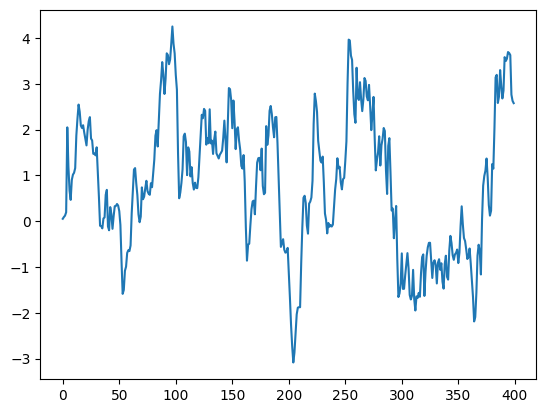

In [100]:
plt.plot(xs.reshape(400,1))

(<matplotlib.patches.Rectangle at 0x137f435e0>,
 (<matplotlib.patches.ConnectionPatch at 0x137fb2520>,
  <matplotlib.patches.ConnectionPatch at 0x137fb2eb0>))

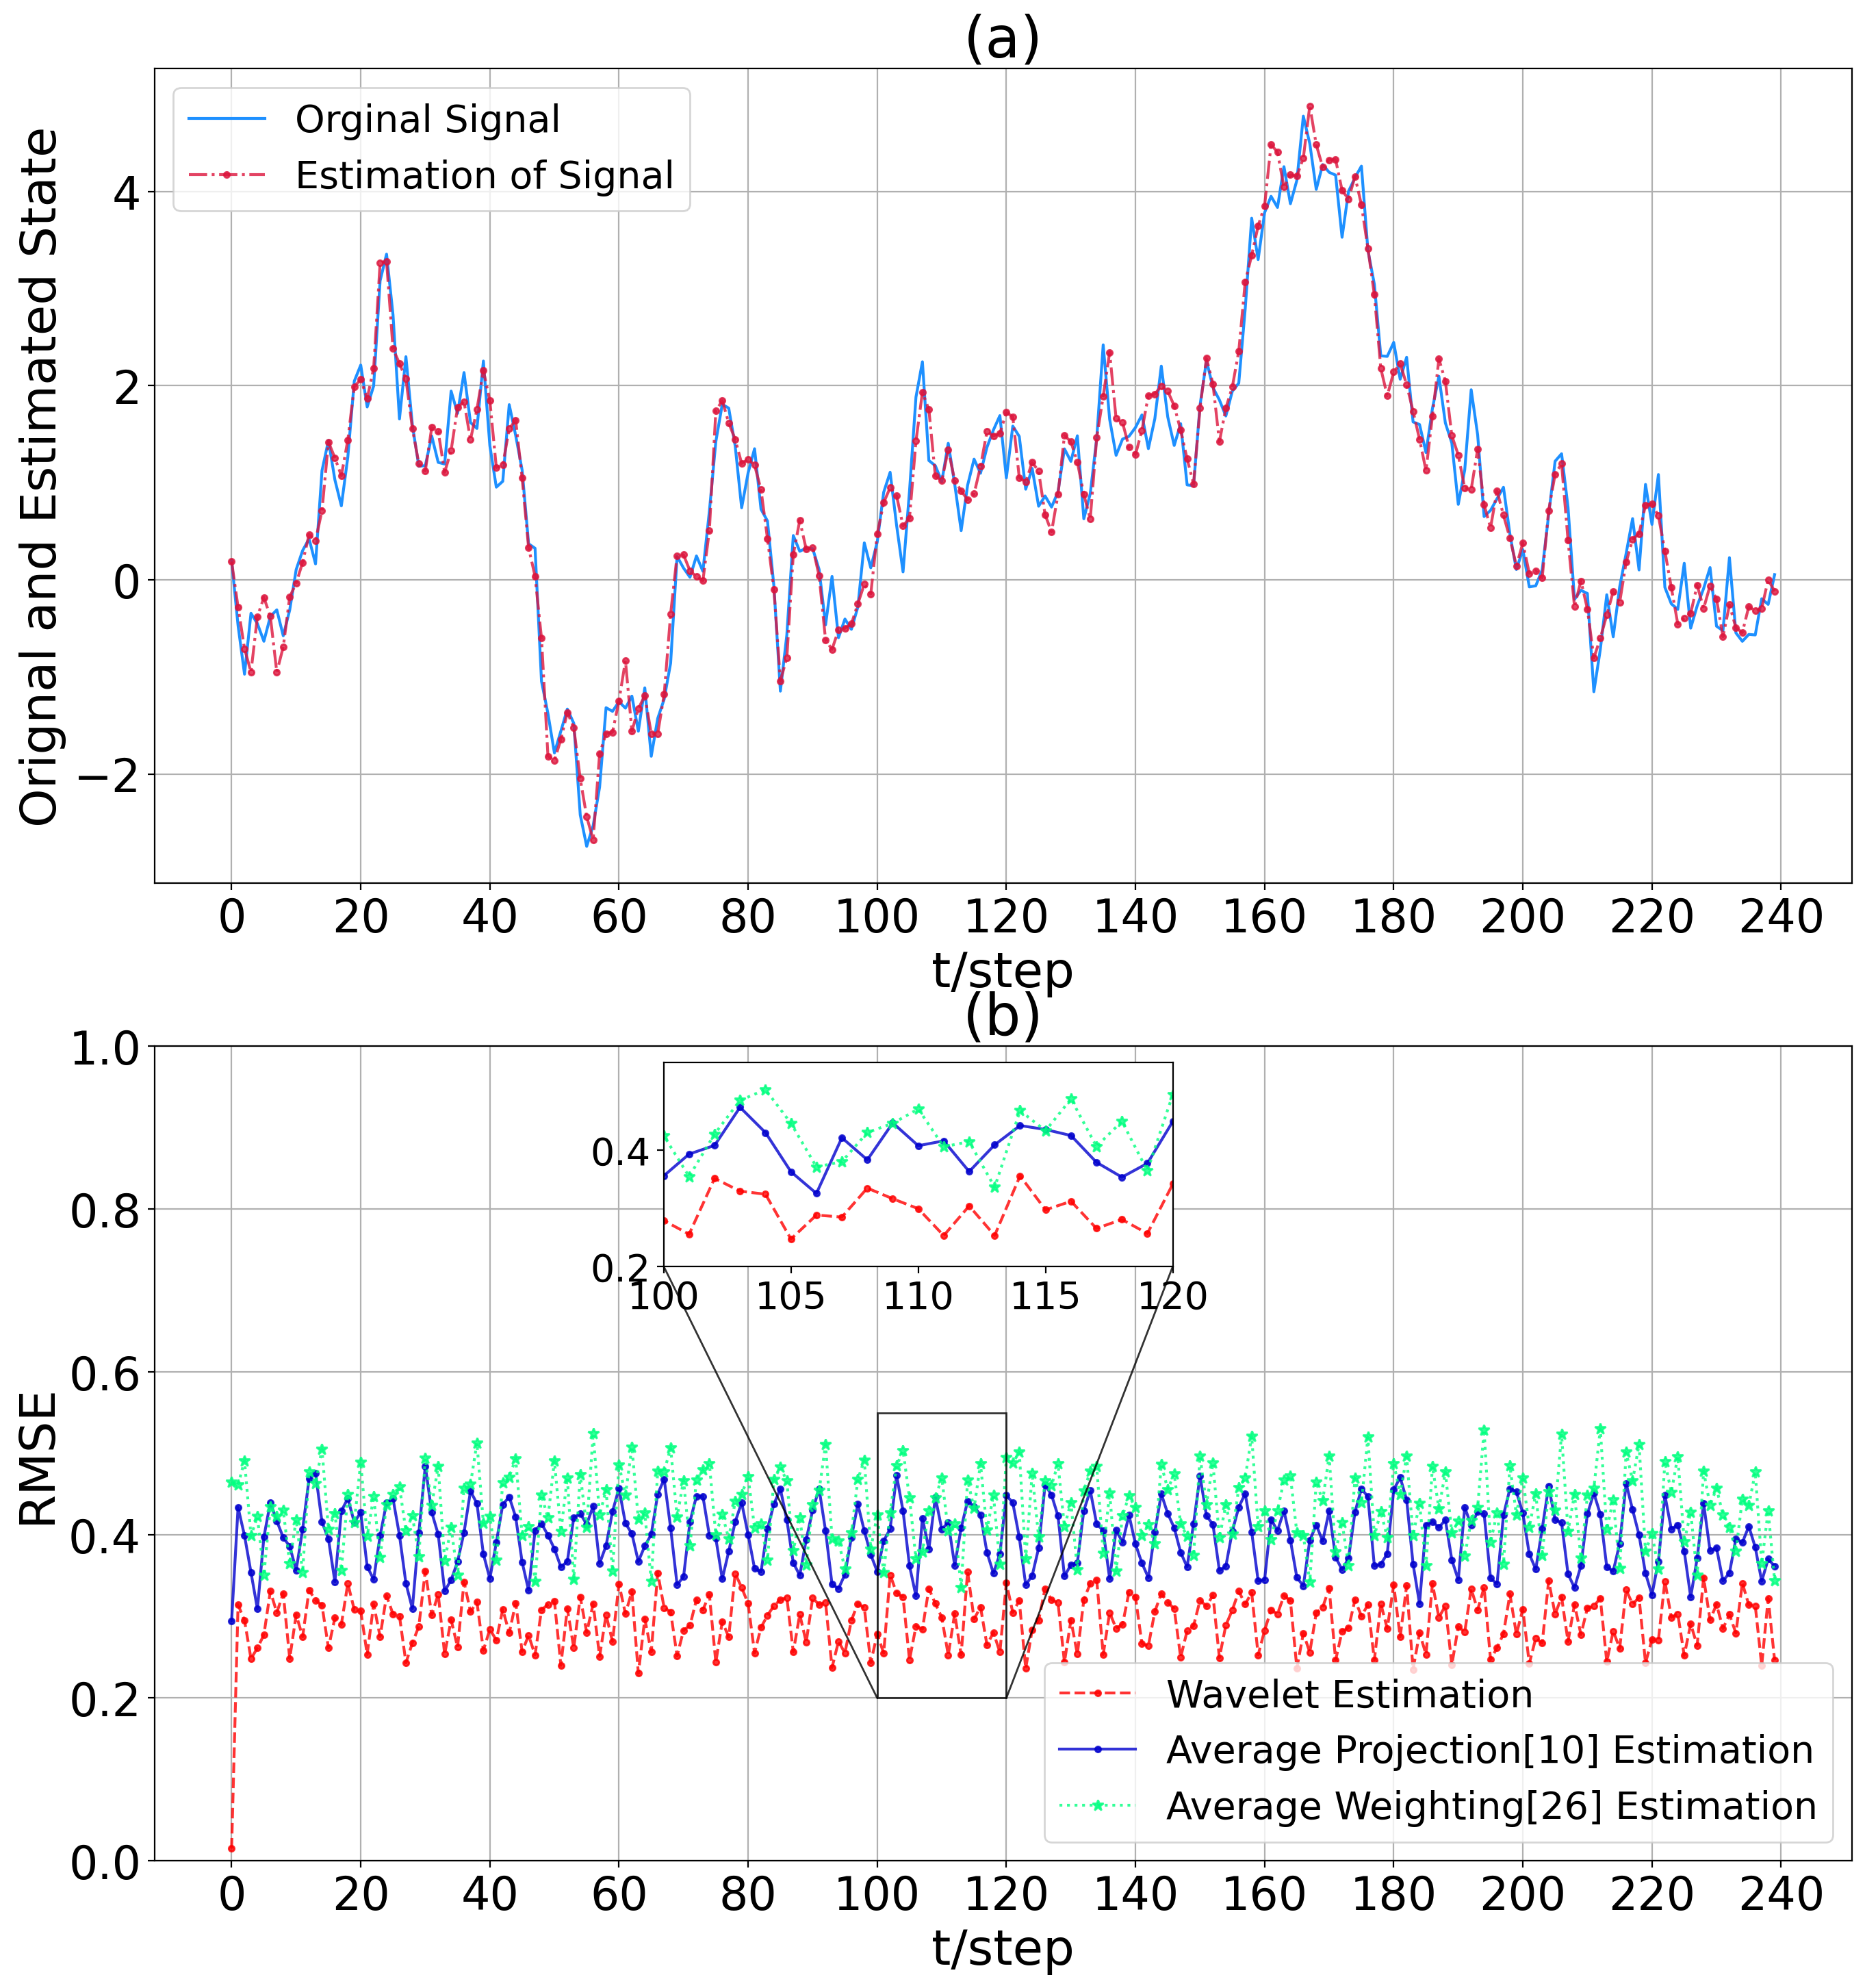

In [14]:
# 创建画布
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 17), dpi=200)
# 图1
# plt.figure(figsize=(10,5),dpi=100)
axes[0].plot(x1[0,:-1],color='dodgerblue',label='Orginal Signal')
axes[0].plot(X_e0.reshape(L1,1),color='crimson',marker='.',linestyle='-.',alpha=0.8,label='Estimation of Signal')
axes[0].grid(visible=True, axis='x')
axes[0].grid(visible=True, axis='y')

x_label = ["{}".format(i) for i in range(L1+20)]
axes[0].set_xticks(range(L1+20)[::20], x_label[::20], fontsize=24)
# axes[0].set_yticks(fontsize=14)
axes[0].tick_params(axis='y', labelsize=24)
axes[0].set_xlabel('t/step', fontsize=26)
axes[0].set_ylabel('Orignal and Estimated State', fontsize=26)
axes[0].set_title('(a)', fontsize=30)
axes[0].legend(fontsize=20)
# 图2
# plt.figure(figsize=(10,5),dpi=100)
axes[1].plot(RMS1.reshape(L1,1),color='r',marker='.',linestyle='--',alpha=0.8,label='Wavelet Estimation')
axes[1].plot(RMS2.reshape(L1,1),color='mediumblue',marker='.',linestyle='-',alpha=0.8,label='Average Projection[10] Estimation')
axes[1].plot(RMS3.reshape(L1,1),color='springgreen',marker='*',linestyle='dotted',alpha=0.8,label='Average Weighting[26] Estimation')
# axes[1].plot(RMS4.reshape(L1,1),color='yellow',marker='d',linestyle='dotted',alpha=0.8,label='Haar Estimation')
axes[1].grid(visible=True, axis='x')
axes[1].grid(visible=True, axis='y')

x_label = ["{}".format(i) for i in range(L1+20)]
axes[1].set_xticks(range(L1+20)[::20], x_label[::20], fontsize=24)
# axes[1].set_yticks(fontsize=14)
axes[1].tick_params(axis='y', labelsize=24)
axes[1].set_ylim(0, 1)
axes[1].set_xlabel('t/step', fontsize=26)
axes[1].set_ylabel('RMSE', fontsize=26)
axes[1].set_title('(b)', fontsize=30)
axes[1].legend(fontsize=20, loc='lower right')
#画小图
axins = axes[1].inset_axes([0.3, 0.73, 0.3, 0.25])
axins.plot(RMS1.reshape(L1,1),color='r',marker='.',linestyle='--',alpha=0.8,label='Wavelet Estimation')
axins.plot(RMS2.reshape(L1,1),color='mediumblue',marker='.',linestyle='-',alpha=0.8,label='Average Projection Estimation')
axins.plot(RMS3.reshape(L1,1),color='springgreen',marker='*',linestyle='dotted',alpha=0.8,label='Average Weighting Estimation')
# axins.plot(RMS4.reshape(L1,1),color='yellow',marker='d',linestyle='dotted',alpha=0.8,label='Haar Estimation')
xz1, xz2, yz1, yz2 = 100, 120, 0.2, 0.55
axins.set_xlim(xz1, xz2)
axins.set_ylim(yz1, yz2)
#控制小图横纵坐标字体大小
axins.tick_params(axis='x', labelsize=20)
axins.tick_params(axis='y', labelsize=20)
# 显示投影线条
axes[1].indicate_inset_zoom(axins, edgecolor="black", alpha=0.8)

In [15]:
fig.savefig('./wavelet_fusion.eps', format='eps', dpi=1000)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


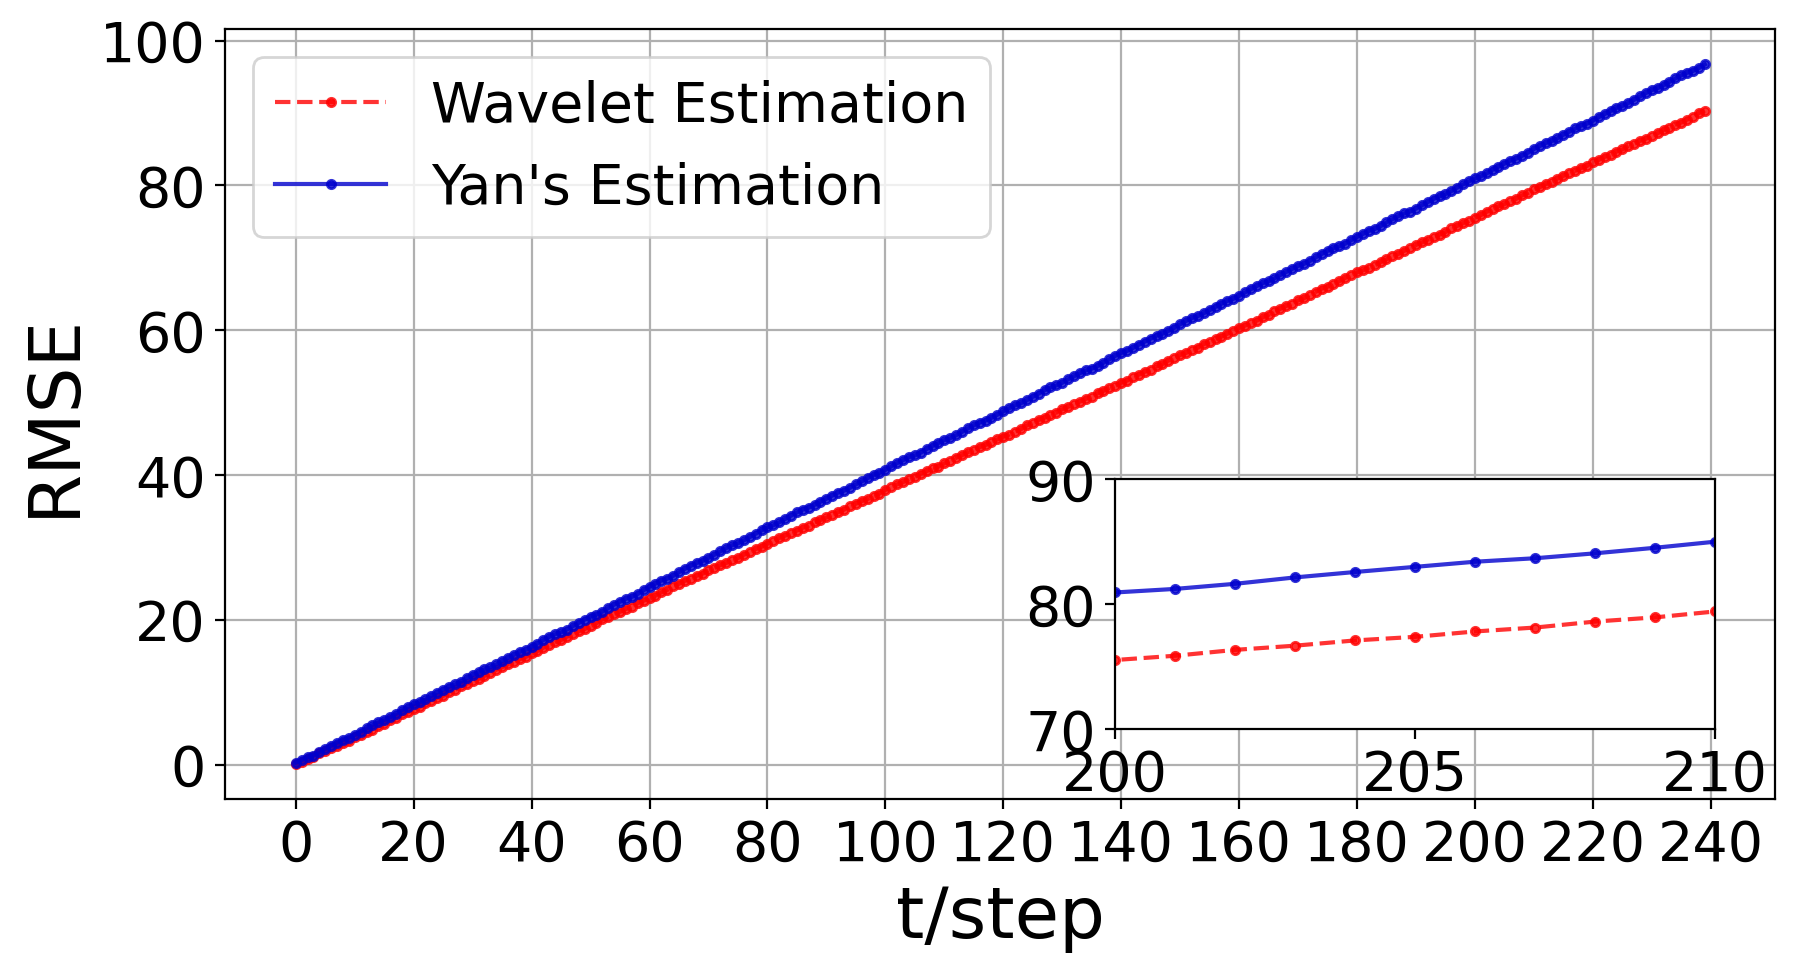

In [29]:
rmse1 = []
rmse2 = []
for i in range(L0):
    rmse1.append(np.sum(RMS1[0:i+1]))
    rmse2.append(np.sum(RMS2[0:i+1]))
rmse1 = asarray(rmse1)
rmse2 = asarray(rmse2)
fig2 = plt.figure(figsize=(10,5),dpi=200)
plt.plot(rmse1.reshape(L0,1),color='r',marker='.',linestyle='--',alpha=0.8,label='Wavelet Estimation')
plt.plot(rmse2.reshape(L0,1),color='mediumblue',marker='.',linestyle='-',alpha=0.8,label='Yan\'s Estimation')
plt.grid(visible=True, axis='x')
plt.grid(visible=True, axis='y')

x_label = ["{}".format(i) for i in range(L0+20)]
plt.xticks(range(L0+20)[::20], x_label[::20], fontsize=20)
y_label = ["{}".format(i) for i in range(100+20)]
plt.yticks(range(100+20)[::20], y_label[::20], fontsize=20)
# plt.tick_params(axis='y', labelsize=20)
# # plt.ylim(0, 1)
plt.xlabel('t/step', fontsize=26)
plt.ylabel('RMSE', fontsize=26)
# plt.title('(b)', fontsize=30)
plt.legend(fontsize=20)
#画小图
axins = fig2.add_axes([0.57, 0.18, 0.3, 0.25])
axins.plot(rmse1.reshape(L0,1),color='r',marker='.',linestyle='--',alpha=0.8,label='Wavelet Estimation')
axins.plot(rmse2.reshape(L0,1),color='mediumblue',marker='.',linestyle='-',alpha=0.8,label='Yan\'s Estimation')
xz1, xz2, yz1, yz2 = 200, 210, 70, 90
axins.set_xlim(xz1, xz2)
axins.set_ylim(yz1, yz2)
#控制小图横纵坐标字体大小
axins.tick_params(axis='x', labelsize=20)
axins.tick_params(axis='y', labelsize=20)
# 显示投影线条
# fig.indicate_add_zoom(axins, edgecolor="black", alpha=0.8)

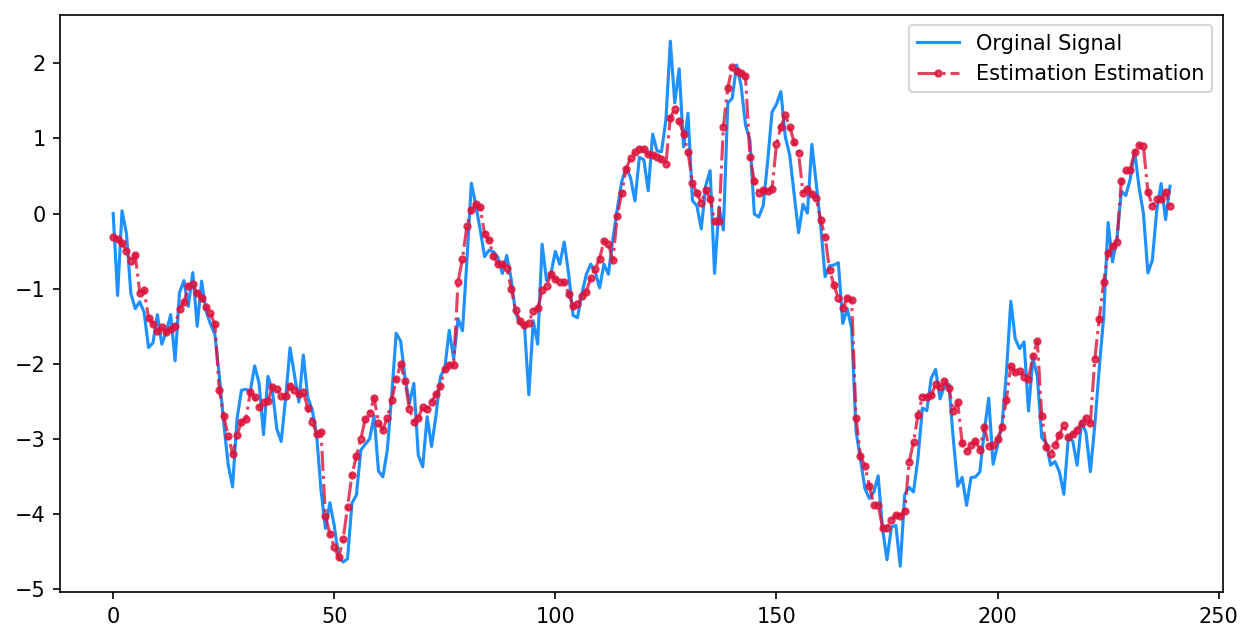

In [147]:
plt.figure(figsize=(10,5),dpi=150)
plt.plot(x1[0,:-1],color='dodgerblue',label='Orginal Signal')
plt.plot(xs2.reshape(L1,),color='crimson',marker='.',linestyle='-.',alpha=0.8,label='Estimation Estimation')
plt.legend()

In [30]:
# 小波
np.sum(RMS1[1:240])/240

0.37639319157006373

In [31]:
# yan
np.sum(RMS2[1:240])/240

0.4018953997380146

In [32]:
# 平均
np.sum(RMS3[1:240])/240

0.4299538191087134

In [33]:
# Haar
np.sum(RMS4[1:240])/240

0.43176989964737267